In [23]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

import pmdarima as pm
from pmdarima import model_selection

from sklearn.metrics import mean_squared_error
import arch

In [10]:
DATA_PATH = os.path.join(os.path.abspath('../../'), 'db', 'data')
# PRIMARY_PATH = os.path.join(DATA_PATH, 'primary')
# SECONDARY_PATH = os.path.join(DATA_PATH, 'secondary')
TERTIARY_PATH = os.path.join(DATA_PATH, 'tertiary')

wpath = os.path.join(DATA_PATH, 'merge')

# GOAL: Garch + ARIMA combined (often best practice)
![Red: ARMA, Green: Garch](https://miro.medium.com/max/862/1*azEK9WckHXBx73L8bTPu6Q.png) Red: ARMA, Green: Garch

In [11]:
#Curency indexes dataframe for EUR currency and limited nr of rows
df = pd.read_csv(os.path.join(wpath, os.path.basename(TERTIARY_PATH), 'idxs_.csv'), parse_dates=['Unnamed: 0'], index_col='Unnamed: 0')
df = df[['EUR']][:20]
# df = df.dropna()

In [39]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 20 entries, 2022-01-02 22:00:00+00:00 to 2022-01-03 17:00:00+00:00
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   EUR         20 non-null     float64
 1   EUR_linear  20 non-null     float64
dtypes: float64(2)
memory usage: 480.0+ bytes


Text(0.5, 1.0, '1st Order Differencing')

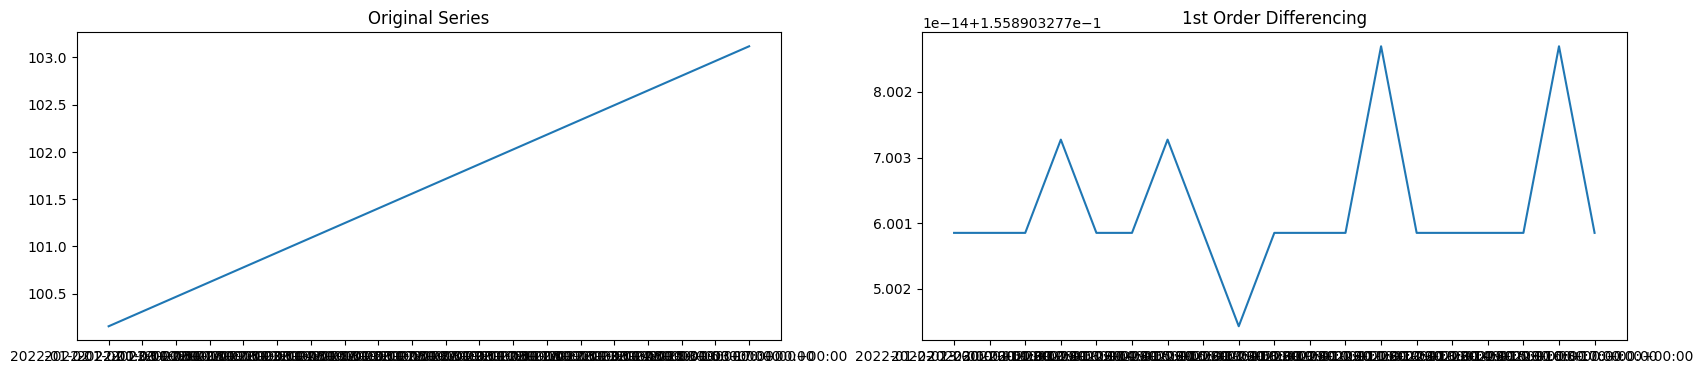

In [12]:
zero_diff = df.EUR
first_order_diff = df.EUR.diff(1)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,4))
ax1.plot(zero_diff); ax1.set_title('Original Series')
ax2.plot(first_order_diff); ax2.set_title('1st Order Differencing')

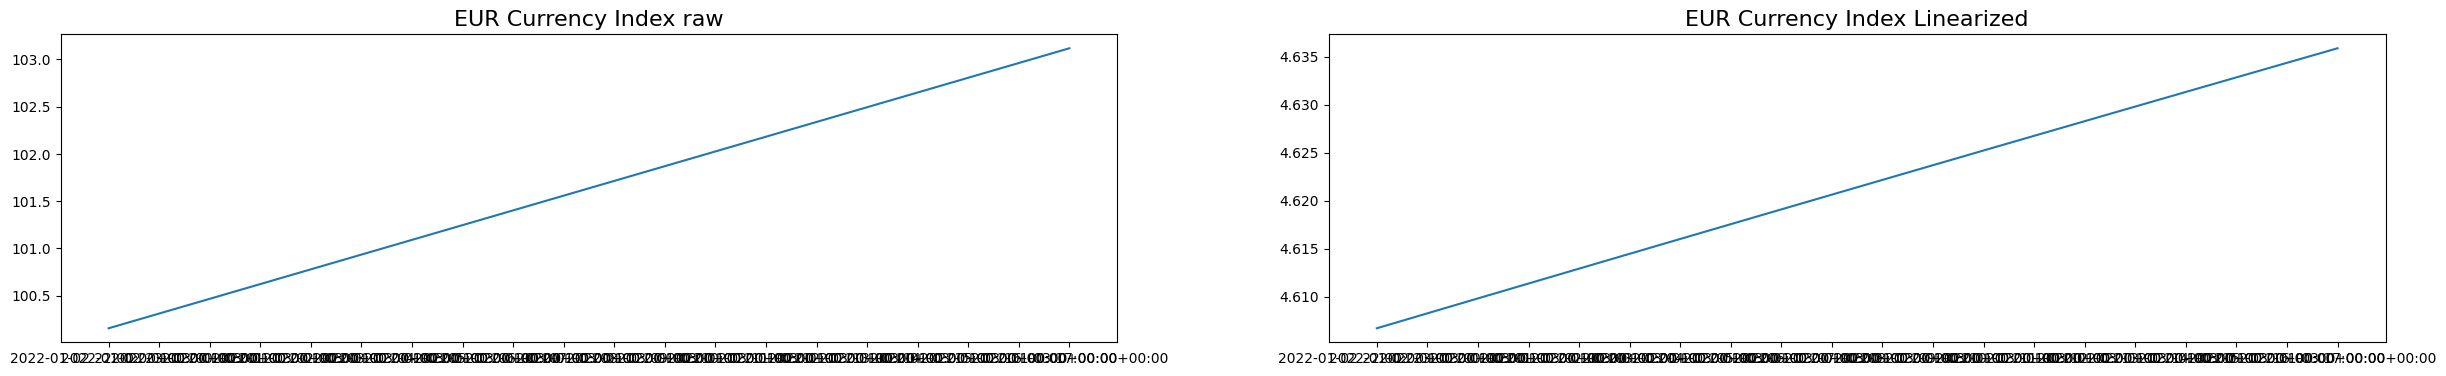

In [14]:
# Remove exponential trend for EUR
plt.figure(figsize=(30,4));

plt.subplot(1,2,1); plt.plot(df.EUR);
plt.title('EUR Currency Index raw', fontsize=16);

df['EUR_linear'] = np.log(df.EUR)

plt.subplot(1,2,2); plt.plot(df['EUR_linear']);
plt.title('EUR Currency Index Linearized', fontsize=16);

In [15]:
print(df.EUR.size)
print(df.EUR_linear.size)

20
20


# check correlation plots

In [16]:
from statsmodels.tsa.stattools import adfuller

adfuller(df.EUR)[1]  # p-value

0.9886388152307602

In [20]:
df.info

<bound method DataFrame.value_counts of                                   EUR  EUR_linear
2022-01-02 22:00:00+00:00  100.155890    4.606728
2022-01-02 23:00:00+00:00  100.311781    4.608283
2022-01-03 00:00:00+00:00  100.467671    4.609836
2022-01-03 01:00:00+00:00  100.623561    4.611386
2022-01-03 02:00:00+00:00  100.779452    4.612934
2022-01-03 03:00:00+00:00  100.935342    4.614480
2022-01-03 04:00:00+00:00  101.091232    4.616023
2022-01-03 05:00:00+00:00  101.247123    4.617564
2022-01-03 06:00:00+00:00  101.403013    4.619103
2022-01-03 07:00:00+00:00  101.558903    4.620639
2022-01-03 08:00:00+00:00  101.714794    4.622173
2022-01-03 09:00:00+00:00  101.870684    4.623704
2022-01-03 10:00:00+00:00  102.026574    4.625233
2022-01-03 11:00:00+00:00  102.182465    4.626760
2022-01-03 12:00:00+00:00  102.338355    4.628285
2022-01-03 13:00:00+00:00  102.494245    4.629807
2022-01-03 14:00:00+00:00  102.650136    4.631326
2022-01-03 15:00:00+00:00  102.806026    4.632844
2022-01-03

In [21]:
# First prepare the diff linearized EUR data
y_diff = df['EUR'].diff().dropna()
y_diff

2022-01-02 23:00:00+00:00    0.15589
2022-01-03 00:00:00+00:00    0.15589
2022-01-03 01:00:00+00:00    0.15589
2022-01-03 02:00:00+00:00    0.15589
2022-01-03 03:00:00+00:00    0.15589
2022-01-03 04:00:00+00:00    0.15589
2022-01-03 05:00:00+00:00    0.15589
2022-01-03 06:00:00+00:00    0.15589
2022-01-03 07:00:00+00:00    0.15589
2022-01-03 08:00:00+00:00    0.15589
2022-01-03 09:00:00+00:00    0.15589
2022-01-03 10:00:00+00:00    0.15589
2022-01-03 11:00:00+00:00    0.15589
2022-01-03 12:00:00+00:00    0.15589
2022-01-03 13:00:00+00:00    0.15589
2022-01-03 14:00:00+00:00    0.15589
2022-01-03 15:00:00+00:00    0.15589
2022-01-03 16:00:00+00:00    0.15589
2022-01-03 17:00:00+00:00    0.15589
Name: EUR, dtype: float64

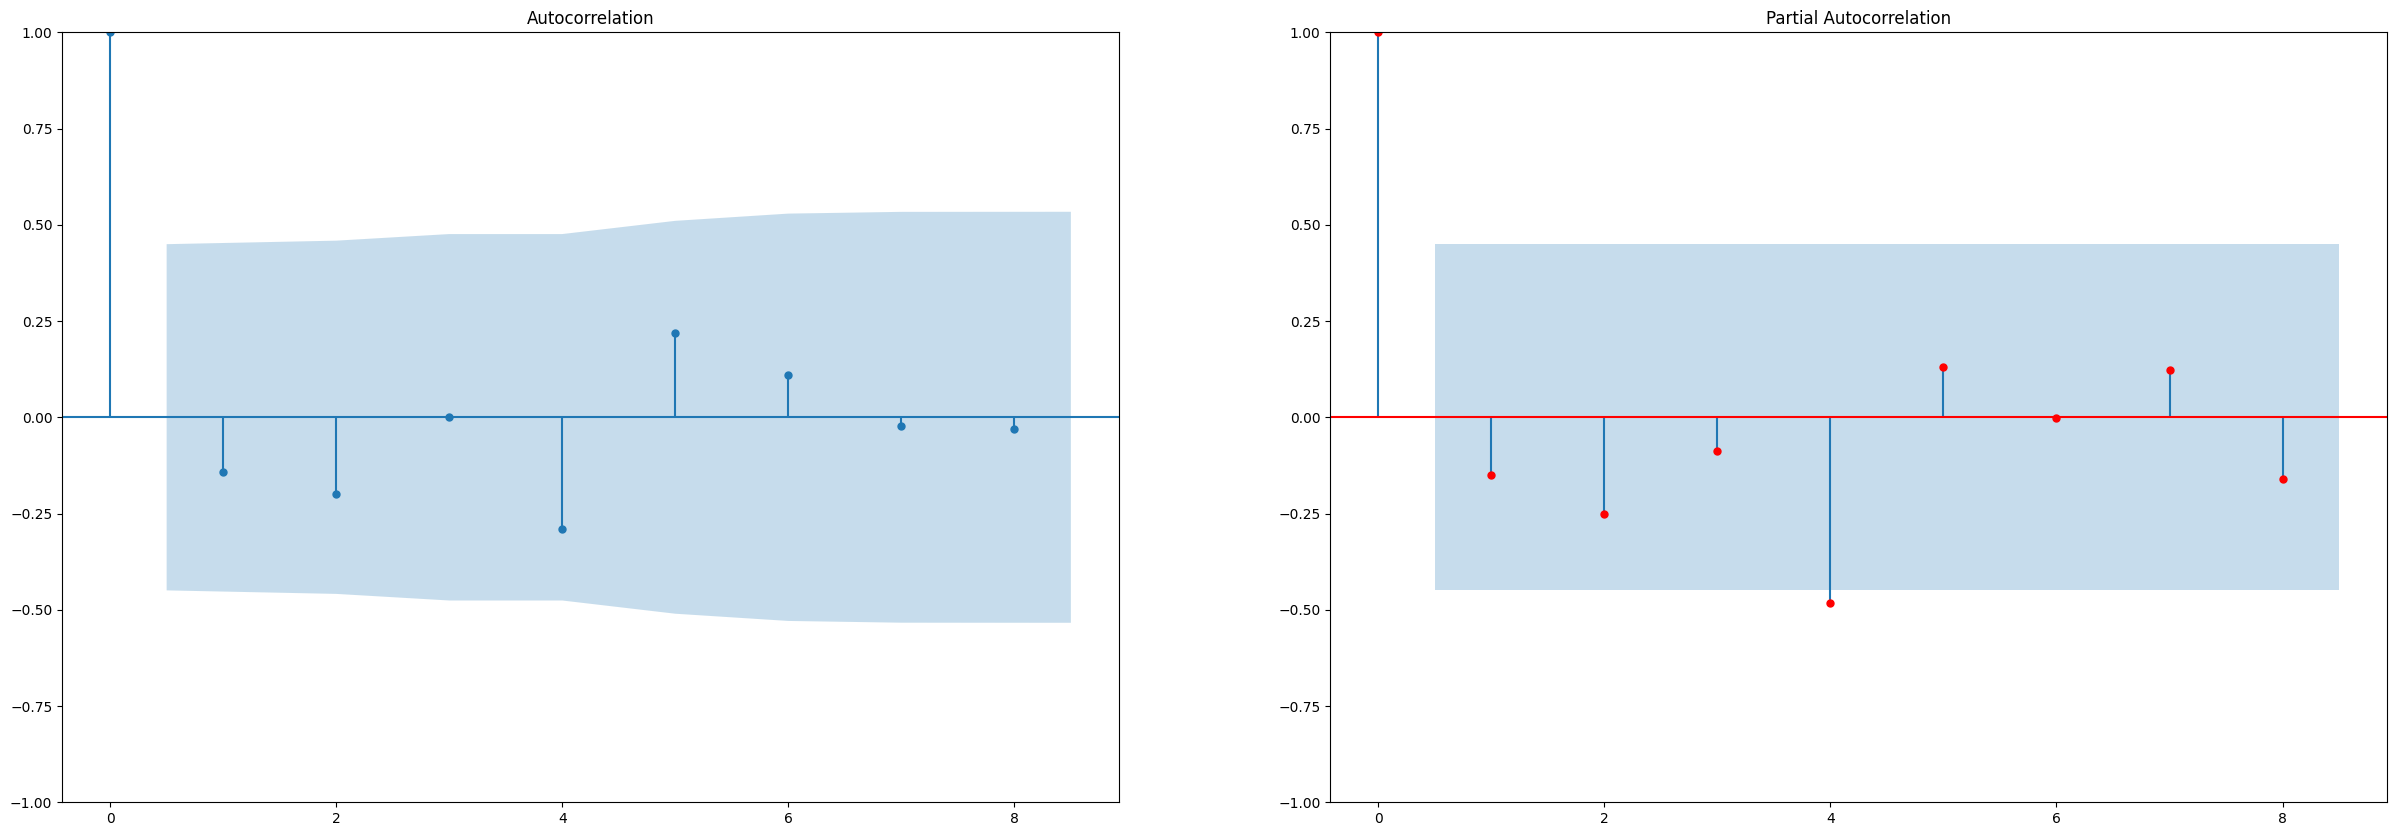

In [25]:
# ACF / PACF analysis of y_diff linearized
fig, axes = plt.subplots(1,2, figsize=(30,10))
plot_acf(y_diff, lags=8, ax=axes[0]); # q=4
plot_pacf(y_diff, lags=8, ax=axes[1], c='r'); #p=6

In [26]:
# fit the model with PMDARIMA pakcage
model = pm.auto_arima(df.EUR)

/Users/pawel/.pyenv/versions/3.8.12/envs/rex-env/lib/python3.8/site-packages/pmdarima/arima/_auto_solvers.py:522: ModelFitWarning: Error fitting  ARIMA(2,1,1)(0,0,0)[0] intercept (if you do not want to see these warnings, run with error_action="ignore").
Traceback:
Traceback (most recent call last):
  File "/Users/pawel/.pyenv/versions/3.8.12/envs/rex-env/lib/python3.8/site-packages/pmdarima/arima/_auto_solvers.py", line 506, in _fit_candidate_model
    fit.fit(y, X=X, **fit_params)
  File "/Users/pawel/.pyenv/versions/3.8.12/envs/rex-env/lib/python3.8/site-packages/pmdarima/arima/arima.py", line 603, in fit
    self._fit(y, X, **fit_args)
  File "/Users/pawel/.pyenv/versions/3.8.12/envs/rex-env/lib/python3.8/site-packages/pmdarima/arima/arima.py", line 524, in _fit
    fit, self.arima_res_ = _fit_wrapper()
  File "/Users/pawel/.pyenv/versions/3.8.12/envs/rex-env/lib/python3.8/site-packages/pmdarima/arima/arima.py", line 510, in _fit_wrapper
    fitted = arima.fit(
  File "/Users/pawel

In [27]:
print(model.order)
print('---===---')
arima_residuals = model.arima_res_.resid
arima_residuals

(1, 1, 0)
---===---


2022-01-02 22:00:00+00:00    99.999999
2022-01-02 23:00:00+00:00    -0.000001
2022-01-03 00:00:00+00:00    -0.000002
2022-01-03 01:00:00+00:00    -0.000002
2022-01-03 02:00:00+00:00    -0.000001
2022-01-03 03:00:00+00:00    -0.000001
2022-01-03 04:00:00+00:00    -0.000001
2022-01-03 05:00:00+00:00    -0.000001
2022-01-03 06:00:00+00:00    -0.000001
2022-01-03 07:00:00+00:00    -0.000001
2022-01-03 08:00:00+00:00    -0.000001
2022-01-03 09:00:00+00:00    -0.000001
2022-01-03 10:00:00+00:00    -0.000001
2022-01-03 11:00:00+00:00    -0.000001
2022-01-03 12:00:00+00:00    -0.000001
2022-01-03 13:00:00+00:00    -0.000001
2022-01-03 14:00:00+00:00    -0.000001
2022-01-03 15:00:00+00:00    -0.000001
2022-01-03 16:00:00+00:00    -0.000001
2022-01-03 17:00:00+00:00    -0.000001
dtype: float64

In [31]:
# fit a GARCH(1,1) model on the residuals of the ARIMA model
garch = arch.arch_model(arima_residuals, p=1, q=1)
garch_fitted = garch.fit()

# Use ARIMA to predict mu
predicted_mu = model.predict(n_periods=1)[0]
# Use GARCH to predict the residual
garch_forecast = garch_fitted.forecast(horizon=1)
predicted_et = garch_forecast.mean['h.1'].iloc[-1]
# Combine both models' output: yt = mu + et
prediction = predicted_mu + predicted_et

Iteration:      1,   Func. Count:      6,   Neg. LLF: 548.1954245466595
Iteration:      2,   Func. Count:     12,   Neg. LLF: 66.89867000435778
Iteration:      3,   Func. Count:     17,   Neg. LLF: 64.19895890025686
Iteration:      4,   Func. Count:     22,   Neg. LLF: 63.159155469837756
Iteration:      5,   Func. Count:     27,   Neg. LLF: 155.18853585487196
Iteration:      6,   Func. Count:     33,   Neg. LLF: 450.2456335617902
Iteration:      7,   Func. Count:     39,   Neg. LLF: 602.8026234853455
Iteration:      8,   Func. Count:     45,   Neg. LLF: 48.323112716583964
Iteration:      9,   Func. Count:     50,   Neg. LLF: 1168565.4584505951
Iteration:     10,   Func. Count:     61,   Neg. LLF: 6318830.455889741
Iteration:     11,   Func. Count:     67,   Neg. LLF: 2317.6302090838785
Iteration:     12,   Func. Count:     73,   Neg. LLF: 150.79029081988816
Iteration:     13,   Func. Count:     79,   Neg. LLF: 61.44698478452727
Iteration:     14,   Func. Count:     85,   Neg. LLF: 91.5

/Users/pawel/.pyenv/versions/3.8.12/envs/rex-env/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


In [33]:
smodel = pm.auto_arima(df.EUR,
                       start_p=1, max_p=4,
                       start_q=1, max_q=4,
                       seasonal=False,
                       trace=True)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-361.823, Time=0.46 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-381.075, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-401.217, Time=0.23 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-372.348, Time=0.52 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-14.707, Time=0.06 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-385.824, Time=0.29 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=nan sec


/Users/pawel/.pyenv/versions/3.8.12/envs/rex-env/lib/python3.8/site-packages/pmdarima/arima/_auto_solvers.py:522: ModelFitWarning: Error fitting  ARIMA(2,1,1)(0,0,0)[0] intercept (if you do not want to see these warnings, run with error_action="ignore").
Traceback:
Traceback (most recent call last):
  File "/Users/pawel/.pyenv/versions/3.8.12/envs/rex-env/lib/python3.8/site-packages/pmdarima/arima/_auto_solvers.py", line 506, in _fit_candidate_model
    fit.fit(y, X=X, **fit_params)
  File "/Users/pawel/.pyenv/versions/3.8.12/envs/rex-env/lib/python3.8/site-packages/pmdarima/arima/arima.py", line 603, in fit
    self._fit(y, X, **fit_args)
  File "/Users/pawel/.pyenv/versions/3.8.12/envs/rex-env/lib/python3.8/site-packages/pmdarima/arima/arima.py", line 524, in _fit
    fit, self.arima_res_ = _fit_wrapper()
  File "/Users/pawel/.pyenv/versions/3.8.12/envs/rex-env/lib/python3.8/site-packages/pmdarima/arima/arima.py", line 510, in _fit_wrapper
    fitted = arima.fit(
  File "/Users/pawel

 ARIMA(1,1,0)(0,0,0)[0]             : AIC=inf, Time=0.24 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0] intercept
Total fit time: 2.063 seconds


In [99]:
arima_residuals_s = smodel.arima_res_.resid
arima_residuals_s

2022-01-03 01:00:00+00:00    0.000010
2022-01-03 02:00:00+00:00   -2.993931
2022-01-03 03:00:00+00:00   -2.355271
2022-01-03 04:00:00+00:00    0.783367
2022-01-03 05:00:00+00:00   -0.190350
                               ...   
2022-03-01 11:00:00+00:00    0.347007
2022-03-01 12:00:00+00:00    0.304542
2022-03-01 13:00:00+00:00    0.230190
2022-03-01 14:00:00+00:00    0.274009
2022-03-01 15:00:00+00:00    0.157132
Length: 999, dtype: float64

In [98]:
# crete differentiated test data
test = df[['EUR']][2000:3000]
test['EUR_linear'] = np.log(abs(test.EUR))

y_test_diff = test['EUR_linear'].diff().dropna()

In [108]:
# fit a GARCH(1,1) model on the residuals of the ARIMA model
garch_s = arch.arch_model(arima_residuals_s, p=1, q=1)
garch_fitted = garch_s.fit()

# Use ARIMA to predict mu
predicted_mu = smodel.predict(n_periods=1)
predicted_mu
# Use GARCH to predict the residual
garch_forecast = garch_fitted.forecast(horizon=1)
predicted_et = garch_forecast.mean['h.1'].iloc[-1]
# Combine both models' output: yt = mu + et
prediction = predicted_mu + predicted_et

Iteration:      1,   Func. Count:      6,   Neg. LLF: 6162.45228934797
Iteration:      2,   Func. Count:     15,   Neg. LLF: 1176203.0982932015
Iteration:      3,   Func. Count:     21,   Neg. LLF: 1080.6715461340536
Iteration:      4,   Func. Count:     27,   Neg. LLF: 2472.675589444697
Iteration:      5,   Func. Count:     33,   Neg. LLF: 952.353877848418
Iteration:      6,   Func. Count:     39,   Neg. LLF: 921.1562655350136
Iteration:      7,   Func. Count:     44,   Neg. LLF: 920.9877236342322
Iteration:      8,   Func. Count:     49,   Neg. LLF: 920.8500147619347
Iteration:      9,   Func. Count:     54,   Neg. LLF: 920.8345252173958
Iteration:     10,   Func. Count:     59,   Neg. LLF: 920.8336706177422
Iteration:     11,   Func. Count:     64,   Neg. LLF: 920.8336679362737
Iteration:     12,   Func. Count:     68,   Neg. LLF: 920.8336654153725
Optimization terminated successfully    (Exit mode 0)
            Current function value: 920.8336679362737
            Iterations: 12
 

/Users/pawel/.pyenv/versions/3.8.12/envs/rex-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/pawel/.pyenv/versions/3.8.12/envs/rex-env/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


In [109]:
prediction

999   -0.11008
dtype: float64

In [ ]:
predicted_mu_1 =model1.predict(n_periods=1)[0]
predicted_mu_2 = model2.predict(n_periods=1)[0]
predicted_mu_s = smodel.predict(n_periods=1)[0]

# with statsmodels for chosen parameters from the ACF and PACF
p, d, q = 6, 1, 4

In [92]:
from statsmodels.tsa.arima.model import ARIMA  #statsmodels 0.12+

model2 = ARIMA(y_diff, order=(6, 1, 4), trend='t')
model2 = model2.fit()
# one-step out-of sample forecast
model2.summary()

/Users/pawel/.pyenv/versions/3.8.12/envs/rex-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/pawel/.pyenv/versions/3.8.12/envs/rex-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/pawel/.pyenv/versions/3.8.12/envs/rex-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/pawel/.pyenv/versions/3.8.12/envs/rex-env/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Lik

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:             EUR_linear   No. Observations:                  999
Model:                 ARIMA(6, 1, 4)   Log Likelihood               -1118.869
Date:                Tue, 30 Aug 2022   AIC                           2261.739
Time:                        14:03:29   BIC                           2320.608
Sample:                             0   HQIC                          2284.115
                                - 999                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1          4.132e-05      0.000      0.187      0.852      -0.000       0.000
ar.L1         -1.7968      0.845     -2.127      0.033      -3.453      -0.141
ar.L2         -1.9870      0.814     -2.440      0.015      -3.583      -0.391
ar.L3         -1.4429      1.017     -1.418      0.156      -3.437       0.551
ar.L4         -0.6840      0.379     -1.804      0.071      -1.427       0.059
ar.L5         -0.4232      0.243     -1.744      0.081      -0.899       0.052
ar.L6         -0.1497      0.134     -1.115      0.265      -0.413       0.113
ma.L1          0.5808      0.846      0.686      0.493      -1.078       2.240
ma.L2         -0.0938      0.229     -0.410      0.682      -0.542       0.354
ma.L3         -0.7536      0.144     -5.235      0.000      -1.036      -0.471
ma.L4         -0.7014      0.748     -0.938      0.348      -2.168       0.765
sigma2         0.5457      0.014     40.166      0.000       0.519       0.572
===================================================================================
Ljung-Box (L1) (Q):                   0.35   Jarque-Bera (JB):             11353.27
Prob(Q):                              0.55   Prob(JB):                         0.00
Heteroskedasticity (H):               0.54   Skew:                            -2.02
Prob(H) (two-sided):                  0.00   Kurtosis:                        19.02
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
import arch

In [ ]:
# fit a GARCH(1,1) model on the residuals of the ARIMA model
garch = arch.arch_model(arima_residuals, p=1, q=1)
garch_fitted = garch.fit()

# Use ARIMA to predict mu
predicted_mu = arima_model.predict(n_periods=1)[0]
# Use GARCH to predict the residual
garch_forecast = garch_model.forecast(horizon=1)
predicted_et = garch_forecast.mean['h.1'].iloc[-1]
# Combine both models' output: yt = mu + et
prediction = predicted_mu + predicted_et